# 0 Setup

### Imports

In [1]:
import os           # file operations
import sys          # system operations
import re           # regular expressions
import pandas as pd # data manipulation
import openai       # OpenAI API

# Get the current working directory (assuming the notebook is in the notebooks folder)
current_dir = os.getcwd()

# Add the parent directory (project root) to the Python path to enable relative imports (from src)
parent_dir = os.path.dirname(current_dir)
sys.path.append(parent_dir)

from src.openai import OpenAIModels, CustomOpenAIClient
from src.embeddings import EmbeddingAnalyzer

### API key
**WARNING**: Do not share any code or commit it to git which includes readable API Keys.

In [2]:
# OpenAI API key
# https://help.openai.com/en/articles/5112595-best-practices-for-api-key-safety

######### EDIT ############
# TODO: Comment out the first line, uncomment the second line below and replace the placeholder with your API key
openai.api_key = os.environ["OPENAI_API_KEY"]
# openai.api_key = "YOUR_API_KEY"
###########################

### Parameter

In [3]:
# Set the paths
input_dir = os.path.join(parent_dir, 'data', 'input')
processed_dir = os.path.join(parent_dir, 'data', 'processed')

######### EDIT ############
# TODO: Adapt the file name, if necessary
# input_file = '2024-06-20_Combined sources_removed exact duplicates.xlsx'
input_file = '2024-06-22_Combined sources_removed exact duplicates.xlsx'
###########################

# 1 Preprocessing

### Loading the data

In [4]:
df = pd.read_excel(os.path.join(input_dir, input_file))

# Calculate an information value which counts for each row how many columns are not NaN (i.e. contain information) + the length of the abstract (normalized by the mean length)
df['InformationValue'] = df.notna().sum(axis=1) + df['Abstract'].str.len() / df['Abstract'].str.len().mean()

df.iloc[30:40]

,Title,Authors,Journal,Publication,Pages,Year,Paper type,Abstract,DE,Subject terms,Author Keywords,Company Entity,NAICS Code,Address,FT,ISSN,DOI,Accession number,UR,InformationValue
30,A CFR1065-COMPLIANT TRANSPORTABLE/ON-ROAD LOW ...,"Wu, Yuebin; Carder, Daniel; Shade, Benjamin; A...",PROCEEDINGS OF THE 2009 SPRING TECHNICAL CONFE...,NaN,12,2009,Proceedings Paper,"In 2007, certification standards for heavy dut...",NaN,NaN,NaN,NaN,NaN,"[Wu, Yuebin; Carder, Daniel; Shade, Benjamin; ...",NaN,NaN,NaN,NaN,NaN,9.347450
31,A City Wide Assessment of the Financial Benefi...,"Concha Larrauri, Paulina; Campos Gutierrez, Ju...",JOURNAL OF THE AMERICAN WATER RESOURCES ASSOCI...,NaN,23,2020,Article,We assess the potential financial benefits of ...,NaN,SYSTEMS; SELECTION; REUSE,water supply; water resource economics; water ...,NaN,NaN,"[Concha Larrauri, Paulina; Campos Gutierrez, J...",NaN,1093-474X,10.1111/1752-1688.12823,NaN,NaN,12.713499
32,A cognition-driven framework for the evaluatio...,"Simoes, Jessica C. M.; Ferreira, Fernando A. F...",MANAGEMENT DECISION,NaN,21,2020,Article,Purpose Capital restrictions normally exist in...,NaN,METHODOLOGICAL PROPOSAL; REAL-ESTATE; ENTREPRE...,Evaluation of startups; Digital economy; Knowl...,NaN,NaN,"[Simoes, Jessica C. M.] Univ Inst Lisbon, ISCT...",NaN,0025-1747,10.1108/MD-09-2019-1253,NaN,NaN,12.755212
33,A cognition-driven framework for the evaluatio...,"Simões, Jéssica C.M. 1 jcmss11@iscte.pt Ferr...",Management Decision,"2020, Vol. 58 Issue 11, p2327-2347",21p,2020,Article,Purpose: Capital restrictions normally exist i...,New business enterprises Statistical decision ...,NaN,Cognitive maps Decision EXpert (DEX) Digital e...,NaN,NaN,"1 ISCTE Business School, University Institute ...",NaN,00251747,10.1108/MD-09-2019-1253,147548824.0,https://search.ebscohost.com/login.aspx?direct...,16.017136
34,A cognitive approach to the expected value of ...,"Boulongne, Romain",STRATEGIC ENTREPRENEURSHIP JOURNAL,NaN,37,2023,Article,"Research Summary Oftentimes, social enterprise...",NaN,CATEGORIZATION; ENTREPRENEURSHIP; ANALOGY; SUS...,categories; cognitive entrepreneurship; experi...,NaN,NaN,"[Boulongne, Romain] IESE Business Sch, Strateg...",NaN,1932-4391,10.1002/sej.1436,NaN,NaN,12.863862
35,A cognitive approach to the expected value of ...,"Boulongne, Romain 1 rboulongne@iese.edu",Strategic Entrepreneurship Journal,"Mar2023, Vol. 17 Issue 1, p95-131",37p,2023,Article,"Research Summary: Oftentimes, social enterpris...",Social enterprises Social services Organizatio...,Social integration Social goals,categories cognitive entrepreneurship experime...,NaN,624190 Other Individual and Family Services,"1 Strategic Management Department, IESE Busine...",19605.0,19324391,10.1002/sej.1436,162398541.0,https://search.ebscohost.com/login.aspx?direct...,19.127726
36,A cognitive map of sustainable decision-making...,"Munoz, Pablo",INTERNATIONAL JOURNAL OF ENTREPRENEURIAL BEHAV...,NaN,27,2018,Article,Purpose Under what conditions do entrepreneurs...,NaN,SELF-EFFICACY; VALUES; OPPORTUNITIES; VENTURES...,Sustainable entrepreneurship; Fuzzy-set qualit...,NaN,NaN,"[Munoz, Pablo] Univ Liverpool, Management Sch,...",NaN,1355-2554,10.1108/IJEBR-03-2017-0110,NaN,NaN,13.140822
37,A comparative analysis of organic substrates f...,"Shabangu, Khaya Pearlman; Mthembu, Nhlanhla; C...",ENERGY REPORTS,NaN,14,2024,Article,This study investigates the startup sequence o...,NaN,POWER-GENERATION; PERFORMANCE; SYSTEM; MFC; BI...,Double Chamber Microbial Fuel Cell (DCMFC); Bi...,NaN,NaN,"[Shabangu, Khaya Pearlman; Chetty, Manimagalay...",NaN,2352-4847,10.1016/j.egyr.2024.02.054,NaN,NaN,12.907031
38,A comparative life cycle analysis of low power...,"Durlinger, Bart; Reinders, Angele; Toxopeus, M...",RENEWABLE ENERGY,NaN,9,2012,Article,This paper evaluates the environmental effects...,NaN,SYSTEMS,LCA; Stand-alone PV systems; Applications,NaN,NaN,"[Reinders, Angele] Delft Univ Technol, Fac Ind...",NaN,0960-1481,10.1016/j.renene.2011.10.006,NaN,Na

### Creating a copy

In [5]:
# Create a copy with only those columns relevant for the analysis, to avoid working with the full dataset
relevant_columns = ['Title', 'Abstract', 'InformationValue', 'Year']
df_processed = df[relevant_columns].copy()

df_processed

,Title,Abstract,InformationValue,Year
0,'I am much more than just a mum'. Social capit...,An earlier article published in this journal s...,11.600969,2006
1,'Nature and Health' in Sweden,"During recent years, Sweden has faced an incre...",12.505574,2006
2,"'The Good, Pure Old Days': Cyclist's Switching...",According to our interpretation of the model o...,12.622311,2014
3,'The plural of silo is not ecosystem': Qualita...,BackgroundInternet of Things (IoT) innovations...,12.919642,2023
4,"'We do good things, don't we?': 'Blended Value...",This paper presents an exploratory analysis of...,11.665964,2009
...,...,...,...,...
4562,"失之东隅, 收之桑榆 -- 品牌排斥和在场第三方顾客品牌评价的关系研究. AT- What ...",Social exclusion involves individual neglect o...,15.695385,2022
4563,新冠肺炎疫情危机下的企业韧性与企业家精神 ----2021·中国企业家成长与发展专题调查报告...,Chinese economy has entered a critical period ...,16.166847,2022
4564,新冠肺炎疫情危机下的企业韧性与企业家精神 --2021·中国企业家成长与发展专题调查报告 A...,"我国经济已迈入创新转型的关键时期, 企业家 调查系统课题组持续多年追踪调研中国企业的创新动向...",16.152781,2023
4565,社会交往对进城农民工创业行为的影响分析. AT- Influence of Social I...,Encouraging urban migrant workers to start the...,14.244136,2023


### Removing non-alphanumeric symbols (e.g. Chinese)

In [6]:
# Define a function to check if the first character is an English symbol
def starts_with_non_english_symbol(text):
    if not text:  # Check if the string is empty
        return False
    first_char = text.strip()[0]  # Strip whitespace before checking the first character
    return not (first_char.isascii() and (first_char.isalpha() or first_char in "'\".,!?"))

# Define a function to remove non-English symbols from a string
def remove_non_english_symbols(text):
    # Strip leading and trailing whitespaces
    text = text.strip()
    # Remove non-ASCII characters
    text = re.sub(r'[^\x00-\x7F]+', '', text)
    return text

# Apply the functions to filter and modify the DataFrame
def process_text(row):
    for column in ['Title', 'Abstract']:
        if starts_with_non_english_symbol(row[column]):
            row[column] = remove_non_english_symbols(row[column])
    return row

df_processed = df_processed.apply(process_text, axis=1)

df_processed

,Title,Abstract,InformationValue,Year
0,'I am much more than just a mum'. Social capit...,An earlier article published in this journal s...,11.600969,2006
1,'Nature and Health' in Sweden,"During recent years, Sweden has faced an incre...",12.505574,2006
2,"'The Good, Pure Old Days': Cyclist's Switching...",According to our interpretation of the model o...,12.622311,2014
3,'The plural of silo is not ecosystem': Qualita...,BackgroundInternet of Things (IoT) innovations...,12.919642,2023
4,"'We do good things, don't we?': 'Blended Value...",This paper presents an exploratory analysis of...,11.665964,2009
...,...,...,...,...
4562,", -- . AT- What We Lose in Hake We Shall Have...",Social exclusion involves individual neglect o...,15.695385,2022
4563,----2021 AT- Organizational Resilience and En...,Chinese economy has entered a critical period ...,16.166847,2022
4564,--2021 AT- Organizational Resilience and Entr...,", 2020 """", , 2020 , , . Chinese econom...",16.152781,2023
4565,. AT- Influence of Social Interaction on the E...,Encouraging urban migrant workers to start the...,14.244136,2023


### Removing duplicates
For a subsequent triplet of titles (lowercased), check if the middle one is contained in one of the others and, if that is the case for a pair, remove the one with the lowest information value

In [7]:
# Print the length of the DataFrame before processing
print(f'Length of the DataFrame before processing: {len(df_processed)}')

# Repeat until the length of the DataFrame does not change anymore
while True:
    length_before = len(df_processed)

    # Initialize the list of indices to drop
    indices_to_drop = []

    # Iterate over the rows using range to avoid index errors after dropping rows
    i = 1
    while i < len(df_processed) - 1:
        # Get the current, previous and next index
        idx1 = df_processed.index[i - 1]
        idx2 = df_processed.index[i]
        idx3 = df_processed.index[i + 1]

        # Get the titles
        title1 = df_processed.loc[idx1, 'Title'].lower()
        title2 = df_processed.loc[idx2, 'Title'].lower()
        title3 = df_processed.loc[idx3, 'Title'].lower()
        
        # Check if the middle title is a substring of the previous or next title
        if title2 in title1:
            # Check the InformationValue
            if df_processed.loc[idx2, 'InformationValue'] >= df_processed.loc[idx1, 'InformationValue']:
                indices_to_drop.append(idx1)
            else:
                indices_to_drop.append(idx2)
        elif title2 in title3:
            # Check the InformationValue
            if df_processed.loc[idx2, 'InformationValue'] >= df_processed.loc[idx3, 'InformationValue']:
                indices_to_drop.append(idx3)
            else:
                indices_to_drop.append(idx2)
        
        # Increment the index
        i += 1

    # Drop the rows with the lower InformationValue
    df_processed.drop(indices_to_drop, inplace=True)

    # Check if the length of the DataFrame has changed
    if len(df_processed) == length_before or len(df_processed) == 1:
        break

# Print the length of the DataFrame
print(f'Length of the DataFrame after processing: {len(df_processed)}')

Length of the DataFrame before processing: 4567
Length of the DataFrame after processing: 3982


# 2 Analysis

### Create the OpenAI client

In [8]:
model = OpenAIModels.TEXT_EMBEDDING_3_LARGE
client = CustomOpenAIClient(model, cost_limit_single_call=0.5, log=True, output_estimate=0)
client.estimation_mode = True # Set this to False to actually call the API

folder_path = os.path.join(parent_dir, 'data', 'processed', 'embeddings')
file_path = os.path.join(folder_path, model.name + '.json')
cost_limit_batch = 0.5

Log file created at 2024-06-21 01:09:14.




### Concatenate all strings which should be embedded

In [9]:
# Create a list of strings to embed
strings = df_processed['Title'].to_list() + df_processed['Abstract'].to_list()

### Estimate the costs

In [10]:
# Call in estimation mode to get the cost estimate
embeddings, embedding_exceptions = client.batch_api_call(strings, folder_path, file_path, cost_limit_batch=cost_limit_batch)

### Create the embeddings of the titles and abstracts

In [11]:
# WARNING: Call in actual mode to get the embeddings
client.estimation_mode = False
embeddings, embedding_exceptions = client.batch_api_call(strings, folder_path, file_path, cost_limit_batch=cost_limit_batch)
client.estimation_mode = True

Calling OpenAI API: 0calls [00:00, ?calls/s]


### Remove duplicates based on the similarities of the titles

In [12]:
######### EDIT ############
# TODO: Adapt the similarity threshold if necessary
similarity_threshold = 0.7
###########################


def get_similar_titles(embeddings, df_processed, similarity_threshold):
    """
    Get similar titles based on the embeddings of the titles.

    Parameters:
    embeddings (dict): A dictionary containing the embeddings of the titles.
    df_processed (DataFrame): A DataFrame containing the processed data.
    similarity_threshold (float): The similarity threshold to consider two titles as similar.

    Returns:
    list: A list of tuples containing the similar titles and their similarity score.
    """
    titles = df_processed['Title'].to_list()
    # Get the similarity matrix of the titles with all other titles
    titles_analyzer = EmbeddingAnalyzer(embeddings, titles, titles)
    similarity_matrix_titles = titles_analyzer.cosine_similarity_matrix()

    # Get all pairs of titles with a similarity of at least similarity_threshold
    similar_titles = []
    similar_titles_count = {0.7: 0, 0.75: 0, 0.8: 0, 0.85: 0, 0.9: 0, 0.95: 0}
    for i in range(len(similarity_matrix_titles)):
        for j in range(i + 1, len(similarity_matrix_titles)):
            if similarity_matrix_titles[i][j] >= similarity_threshold:
                similar_titles.append((titles[i], titles[j], similarity_matrix_titles[i][j]))
            for threshold in similar_titles_count.keys():
                if similarity_matrix_titles[i][j] >= threshold:
                    similar_titles_count[threshold] += 1

    print(f'\nTitle pairs with a similarity above the threshold of {similarity_threshold}: {len(similar_titles)}\n')
    for threshold, count in similar_titles_count.items():
        print(f'Title pairs with a similarity above the threshold of {threshold}: {count}')

    return similar_titles

similar_titles = get_similar_titles(embeddings, df_processed, similarity_threshold)

Shape of sentence embeddings:       (3982, 3072)
Shape of topic embeddings:          (3982, 3072)
Shape of cosine similarity matrix:  (3982, 3982)

Title pairs with a similarity above the threshold of 0.7: 635

Title pairs with a similarity above the threshold of 0.7: 635
Title pairs with a similarity above the threshold of 0.75: 219
Title pairs with a similarity above the threshold of 0.8: 115
Title pairs with a similarity above the threshold of 0.85: 81
Title pairs with a similarity above the threshold of 0.9: 59
Title pairs with a similarity above the threshold of 0.95: 36


In [13]:
# Sort the similar titles by similarity in descending order
similar_titles.sort(key=lambda x: x[2], reverse=False)

for title1, title2, similarity in similar_titles:
    print(f'Title 1: {title1}')
    print(f'Title 2: {title2}')
    print(f'Similarity: {similarity}')
    print()

Title 1: ADVANCING ENTREPRENEURSHIP EDUCATION: A NEW APPROACH IN ROMANIAN ACADEMIA
Title 2: ENTREPRENEURSHIP IN ROMANIA. A BEHAVIORAL ECONOMICS PERSPECTIVE. 
Similarity: 0.7001092999561345

Title 1: Human flourishing: an enabler of entrepreneurial intention in Latin American students. GE- Mexico 
Title 2: Social Entrepreneurship, Complex Thinking, and Entrepreneurial Self-Efficacy: Correlational Study in a Sample of Mexican Students. GE- Mexico 
Similarity: 0.7001557827643673

Title 1:         . AT- Modeling the Social Orientation of the Business Entities Activities in the Agricultural Sector. LA- Ukrainian GE- Ukraine LK- Language of Keywords: English; Ukrainian
Title 2:        -  . AT- Developing the Tourism Sector of a Region through Forming Territorial and Production Integration Structures. LA- Ukrainian LK- Language of Keywords: English; Ukrainian
Similarity: 0.7002030327411

Title 1: Developing Indicators for Sustainable Entrepreneurship in Flemish Agriculture
Title 2: Identifica

In [14]:
######### EDIT ############
# TODO: Adapt the window size if necessary
window_size = 5
###########################

indeces_to_remove = []

# Iterate over the similar titles

for title1, title2, similarity in similar_titles:
    # Lowercase and remove all , and . and : and ' and ‘ as well as "language of keywords", then split with whitespace to get the tokens
    words1 = title1.lower().replace(',', '').replace('.', '').replace(':', '').replace("'", '').replace('‘', '').replace('language of keywords', '').split()
    words2 = title2.lower().replace(',', '').replace('.', '').replace(':', '').replace("'", '').replace('‘', '').replace('language of keywords', '').split()
    # Remove tokens that end with a - and replace - with whitespace (for all other tokens)
    words1 = [word.replace('-', ' ') for word in words1 if not word.endswith('-')]
    words2 = [word.replace('-', ' ') for word in words2 if not word.endswith('-')]

    # With a sliding window, check if their are at least once window_size words in common, independent of the position but in the same order
    # If so, add the index of the one with the lower InformationValue to the list of indeces to remove
    for i in range(len(words1) - window_size + 1):
        for j in range(len(words2) - window_size + 1):
            if len(set(words1[i:i+window_size]).intersection(words2[j:j+window_size])) >= window_size:
                # Get the index of the title with the lower InformationValue
                try:
                    idx1 = df_processed[df_processed['Title'] == title1]['InformationValue'].idxmin()
                    idx2 = df_processed[df_processed['Title'] == title2]['InformationValue'].idxmin()
                    if df_processed.loc[idx1, 'InformationValue'] < df_processed.loc[idx2, 'InformationValue']:
                        indeces_to_remove.append((idx1,idx2))
                    else:
                        indeces_to_remove.append((idx2,idx1))
                except:
                    pass

indeces_to_remove = list(set(indeces_to_remove))

# Print the titles of the pairs (removed, keep)
print(f'Number of pairs to remove: {len(indeces_to_remove)}\n')
for idx1, idx2 in indeces_to_remove:
    print(f'Removed: {df_processed.loc[idx1, "Title"]}')
    print(f'Keep: {df_processed.loc[idx2, "Title"]}')
    print()

print("\n",40*"#", "\n")

# Drop the rows with the lower InformationValue
df_processed.drop([idx1 for idx1, idx2 in indeces_to_remove], inplace=True)

# Update the list of strings
strings = df_processed['Title'].to_list() + df_processed['Abstract'].to_list()

# Get the similar titles with the new DataFrame
similar_titles = get_similar_titles(embeddings, df_processed, similarity_threshold)

Number of pairs to remove: 127

Removed: Policy support for own-brand innovation in China's auto industry: panacea or placebo?
Keep: Policy support for own-brand innovation in China’s auto industry: panacea or placebo? GE- China 

Removed: Successful US entrepreneurs: Identifying ethical decision-making and social responsibility behaviors
Keep: Successful U.S. Entrepreneurs: Identifying Ethical Decision-making and Social Responsibility Behaviors. GE- United States 

Removed: Does Social Proximity Enhance Business Partnerships? Theory and Evidence from Ethnicity's Role in US Venture Capital
Keep: Does Social Proximity Enhance Business Partnerships? Theory and Evidence from Ethnicity's Role in U.S. Venture Capital. IL- 1 Black and White Photograph, 1 Diagram, 10 Charts, 2 Graphs GE- United States 

Removed: An Empiric Experience Implementing a Methodology to Improve the Entrepreneurial Support System: Creating Social Value Through Collaboration and Co-creation
Keep: Experimenting a metho

In [15]:
# Sort the similar titles by similarity in ascending order
similar_titles.sort(key=lambda x: x[2], reverse=False)

# Display the similar titles with a similarity above 0.8
for title1, title2, similarity in similar_titles:
    if similarity >= 0.8:
        print(f'Title 1: {title1}')
        print(f'Title 2: {title2}')
        print(f'Similarity: {similarity}')
        print()

Title 1:          . AT- Indicative assessment of the innovative development effectiveness of entrepreneurship in the agricultural sector of the economy. AT-          . LA- Ukrainian LK- Language of Keywords: English; Russian; Ukrainian
Title 2:     -    AT- Development of farms in the organizational and economic support of employment of the population. AT-     -    LA- Ukrainian GE- Ukraine LK- Language of Keywords: English; Russian; Ukrainian
Similarity: 0.8008015821553157

Title 1:        :   AT- Institutional analysis of entrepreneurship development in the agrarian sector of economy: methodical aspect. AT-        :   LA- Ukrainian LK- Language of Keywords: English; Russian; Ukrainian
Title 2: -         AT- Organizational-economic socialization of entrepreneurship under the conditions of economic transformation. AT- -         LA- Ukrainian LK- Language of Keywords: English; Russian; Ukrainian
Similarity: 0.8026792356356272

Title 1: Pathways to social value and social change: An inte

### Define the search queries

In [16]:
######### EDIT ############
# TODO: Adapt the queries if necessary
# Structure: {query abbreviation: (query, weight)}
queries = {
    "IM-S": ("impact measurement", 1),
    "IM-L": ("processes of capturing and communicating valued information about the effects of social interventions—that is, whether and how a change in condition has occurred", 1),
    "MEA": ("measurement", 0.2),
    "EVA": ("evaluation", 0.2),
    "MON": ("monitoring", 0.2),
    "REP": ("reporting", 0.2),
    "ACC": ("accounting", 0.2),
    "REM": ("research metrics", -1),
    "EIM": ("economic impact", -1),
    "SUS": ("sustainability", 0.5),
    "SOC": ("social impact", 0.5),
    "ENV": ("environmental impact", 0.5),
    "VEN": ("ventures", 0.5),
    "ENT": ("entrepreneurship", 0.5),
    "STP": ("startups", 0.5),
}
# TODO: Adapt the reference year and step size if necessary
reference_year = 2018           # Reference year for the publication date
reward_punishment_step = 0.01    # Step size for the reward/punishment mechanism (e.g. one year after reference year = +1%, two years before reference year = -2%)
###########################

# Create a list of queries
query_list = [query for key, (query, weight) in queries.items()]

### Create the embeddings for the search queries

In [17]:
# WARNING: Call in actual mode to get the embeddings
client.estimation_mode = False
embeddings, embedding_exceptions = client.batch_api_call(query_list, folder_path, file_path, cost_limit_batch=cost_limit_batch)
client.estimation_mode = True

Calling OpenAI API: 0calls [00:00, ?calls/s]


### Calculate the cosine similarity for all query-title and query-abstract combinations

In [27]:
analyzer = EmbeddingAnalyzer(embeddings, strings, query_list)
similarity = analyzer.cosine_similarity_matrix()

Shape of sentence embeddings:       (7716, 3072)
Shape of topic embeddings:          (15, 3072)
Shape of cosine similarity matrix:  (7716, 15)


### Normalise the similarity matrix

In [28]:
# Normalise the similarity matrix, there's no function in the EmbeddingAnalyzer for this
similarity_normalized = (similarity - similarity.min()) / (similarity.max() - similarity.min())

### Assign the score to the DataFrame

In [30]:
# For each query, add one column to the DataFrame with the similarity values for the title and one for the abstract, using the query abbreviation as a prefix
# The shape of the similarty matrix is (len(strings), len(query_list)), where the first half corresponds to the titles and the second half to the abstracts
for key, (query, weight) in queries.items():
    df_processed[key + '_Title'] = similarity_normalized[:len(strings) // 2, query_list.index(query)]
    df_processed[key + '_Abstract'] = similarity_normalized[len(strings) // 2:, query_list.index(query)]

df_processed

,Title,Abstract,InformationValue,Year,IM-S_Title,IM-S_Abstract,IM-L_Title,IM-L_Abstract,MEA_Title,MEA_Abstract,...,SOC_Title,SOC_Abstract,ENV_Title,ENV_Abstract,VEN_Title,VEN_Abstract,ENT_Title,ENT_Abstract,STP_Title,STP_Abstract
0,'I am much more than just a mum'. Social capit...,An earlier article published in this journal s...,11.600969,2006,0.386719,0.410433,0.461980,0.631334,0.215128,0.124727,...,0.418882,0.490731,0.239696,0.276720,0.268551,0.305844,0.374327,0.383961,0.337727,0.375200
1,'Nature and Health' in Sweden,"During recent years, Sweden has faced an incre...",12.505574,2006,0.245343,0.276523,0.257014,0.387881,0.183770,0.098717,...,0.305263,0.354933,0.424581,0.334094,0.234482,0.251455,0.256245,0.276057,0.278250,0.331937
2,"'The Good, Pure Old Days': Cyclist's Switching...",According to our interpretation of the model o...,12.622311,2014,0.253168,0.340297,0.446833,0.513090,0.193689,0.203854,...,0.361761,0.464475,0.243362,0.332401,0.132940,0.255552,0.149948,0.300625,0.194220,0.322736
3,'The plural of silo is not ecosystem': Qualita...,BackgroundInternet of Things (IoT) innovations...,12.919642,2023,0.359862,0.484814,0.434910,0.533674,0.235569,0.223969,...,0.390669,0.516930,0.375501,0.406638,0.310087,0.300222,0.383401,0.357920,0.449578,0.437247
5,"We do good things, dont we?: Blended Value Acc...",Abstract: This paper presents an exploratory a...,15.932253,2009,0.651273,0.532525,0.633237,0.620943,0.301815,0.222327,...,0.522655,0.499183,0.378938,0.379246,0.511060,0.406779,0.565589,0.508956,0.507787,0.431230
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4561,. AT- EXPLORATION ON THE AQUAPONICS MECHANISM ...,Aquaponics is frequently posited as one of the...,17.998378,2021,0.343760,0.354901,0.364242,0.413975,0.335667,0.204653,...,0.261684,0.369898,0.418825,0.474077,0.386589,0.336232,0.367822,0.412219,0.353813,0.368994
4562,", -- . AT- What We Lose in Hake We Shall Have...",Social exclusion involves individual neglect o...,15.695385,2022,0.355301,0.390428,0.335785,0.400943,0.342684,0.165975,...,0.357749,0.620557,0.341873,0.376691,0.267474,0.223474,0.317008,0.358334,0.283700,0.302405
4563,----2021 AT- Organizational Resilience and En...,Chinese economy has entered a critical period ...,16.166847,2022,0.403567,0.372983,0.357173,0.343264,0.239875,0.165483,...,0.418985,0.415843,0.356980,0.358723,0.432200,0.307982,0.661269,0.506933,0.537831,0.387504
4565,. AT- Influence of Social Interaction on the E...,Encouraging urban migrant workers to start the...,14.244136,2023,0.472358,0.468166,0.443076,0.431100,0.279438,0.236662,...,0.590193,0.572317,0.418744,0.371711,0.407799,0.368987,0.598518,0.629628,0.503969,0.498770


### Calculate the relevance score

In [31]:
# Calculate two relevance scores per row, one for the title and one for the abstract, by summing the weighted similarity values
# The weights are defined in the queries dictionary
df_processed['Relevance_Title'] = sum(df_processed[key + '_Title'] * weight for key, (query, weight) in queries.items())
df_processed['Relevance_Abstract'] = sum(df_processed[key + '_Abstract'] * weight for key, (query, weight) in queries.items())

# Calculate a combined relevance score by summing the relevance scores for the title and the abstract
df_processed['Relevance'] = df_processed['Relevance_Title'] + df_processed['Relevance_Abstract']

# Assign percentiles based on the combined relevance score
df_processed['RelevancePercentile'] = df_processed['Relevance'].rank(pct=True)

# Add a column for a year adjusted relevance score
df_processed['RelevanceYearAdjusted'] = df_processed['Relevance'] * (1 + reward_punishment_step * (df_processed['Year'] - reference_year))

# Assign percentiles based on the year adjusted relevance score
df_processed['RelevanceYearAdjustedPercentile'] = df_processed['RelevanceYearAdjusted'].rank(pct=True)

### Export

In [32]:
# Create a DataFrame 'df_removed' with the indices that are removed from 'df_processed' (i.e. the duplicates), and save the corresponding rows from 'df' to a new Excel file
df_removed = df[~df.index.isin(df_processed.index)]
df_removed.to_excel(os.path.join(processed_dir, 'Removed duplicates.xlsx'), index=False)

# Create a DataFrame 'df_analysis' with the indices that are kept in 'df_processed', add the columns of 'df_processed' that are not in 'df' and save the final DataFrame to a new Excel file
df_analysis = df.loc[df_processed.index]
df_analysis = pd.concat([df_analysis, df_processed.drop(columns=relevant_columns)], axis=1)
df_analysis.to_excel(os.path.join(processed_dir, 'Analysis.xlsx'), index=False)

# Appendix

### Similarities of the queries

Shape of sentence embeddings:       (15, 3072)
Shape of topic embeddings:          (15, 3072)
Shape of cosine similarity matrix:  (15, 15)


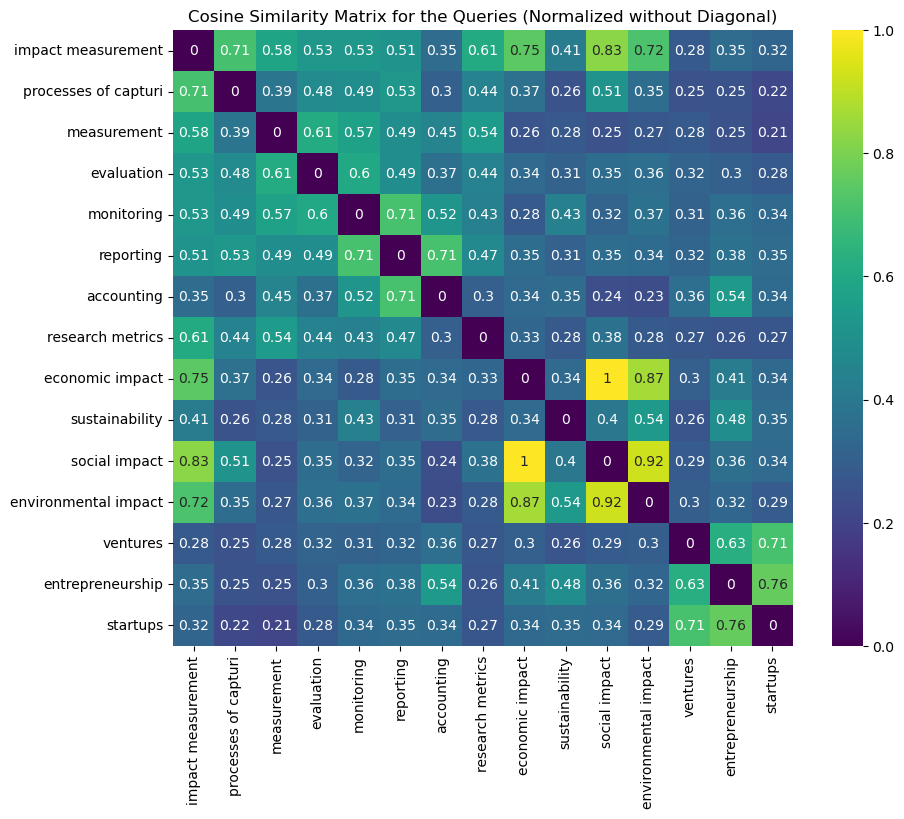

In [34]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# Calculate the similarity matrix for the queries
query_analyzer = EmbeddingAnalyzer(embeddings, query_list, query_list)
query_similarity = query_analyzer.cosine_similarity_matrix()

# Set the diagonal to zero
query_similarity = query_similarity - query_similarity * np.eye(len(query_similarity))

# Normalize the similarity matrix
query_similarity = (query_similarity - query_similarity.min()) / (query_similarity.max() - query_similarity.min())

# Visualize the similarity matrix as a heatmap
# Cut labels to 20 characters
query_labels = [query[:20] for query in query_list]
plt.figure(figsize=(10, 8))
sns.heatmap(query_similarity, annot=True, xticklabels=query_labels, yticklabels=query_labels, cmap='viridis')
plt.title('Cosine Similarity Matrix for the Queries (Normalized without Diagonal)')
plt.show()